In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})

import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [8]:
pv1 = pd.read_csv('./pv_01Sep21.csv')
pv2 = pd.read_csv('./pv_01Oct21.csv')
pv3 = pd.read_csv('./pv_01Nov21.csv')


In [36]:
df_pv = pv1.merge(pv2, on='TRO_MEMBERS', how='outer').merge(pv3, on='TRO_MEMBERS', how='outer').rename(
                                columns={'COUNT_VIEW_PRODUCT_x':'PV_2021-09',
                                        'COUNT_VIEW_PRODUCT_y':'PV_2021-10',
                                        'COUNT_VIEW_PRODUCT':'PV_2021-11'})

In [37]:
df_pv.head()

,TRO_MEMBERS,PV_2021-09,PV_2021-10,PV_2021-11
0,9990010021450334,21.0,11.0,4.0
1,9990010021508161,67.0,50.0,77.0
2,9990010021520295,5.0,8.0,13.0
3,9990010021521900,71.0,50.0,17.0
4,9990010021526743,2.0,1.0,3.0


In [18]:
from datetime import datetime
now = datetime.now()
now_ = datetime(now.year, now.month, now.day)
## 9990010000070044
# sample with minus

q = '''

select 
    ttdr.tbtdr_created_date, 
    ttdr.tbtdr_ponta_user AS TRO_MEMBERS, 
    ttdr.tbtdr_tbto_id, 
    ttdr.tbtdr_rating AS rating
from 
    tb_transaction_delivery_rating ttdr 
where 
    ttdr.tbtdr_created_date between '2021-09-01' and '2021-12-01'
    and ttdr.tbtdr_rating > 0
'''.format(now_)

con, cur = ds_db.connect_prd_order_4()
df_re = pd.read_sql(q, con)


con.close()

df_re['created_date'] = df_re['tbtdr_created_date'].dt.strftime('%Y-%m')
df_re = df_re[df_re['tro_members'] != '']
# df_re_g = df_re.groupby(['tro_members','created_date']).agg({'rating':'mean'})

df_re_g = df_re.groupby(['tro_members', 'created_date']).agg(
                                        rating_below = ('rating', lambda x: len(x[x<3])),
                                        rating_avg = ('rating','mean')
                            )
df_re_g_u = df_re_g.unstack(level=1).fillna(0).reset_index()
df_re_g_u.columns = [' '.join(col).strip().upper() for col in df_re_g_u.columns.values]

df_re_g_u.head(20)

You are connected


,TRO_MEMBERS,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,9990010000069277,0.0,0.0,0.0,5.0,0.0,0.0
1,9990010000070044,0.0,0.0,0.0,5.0,0.0,0.0
2,9990010000089999,0.0,0.0,0.0,0.0,5.0,0.0
3,9990010000191790,0.0,0.0,0.0,0.0,5.0,0.0
4,9990010000196641,0.0,0.0,0.0,5.0,5.0,0.0
5,9990010000198083,0.0,0.0,0.0,0.0,5.0,0.0
6,9990010000208214,0.0,0.0,0.0,5.0,5.0,0.0
7,9990010000209455,0.0,0.0,0.0,5.0,0.0,0.0
8,9990010000209683,0.0,0.0,1.0,0.0,5.0,1.0
9,9990010000212946,0.0,0.0,0.0,0.0,5.0,0.0


In [19]:
df_re['tbtdr_created_date'].min(), df_re['tbtdr_created_date'].max()

(Timestamp('2021-09-01 00:16:15.200000'),
 Timestamp('2021-11-30 23:51:16.002000'))

In [20]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-07-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Jul21 01Aug21
01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [21]:
df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')
df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-08-01') \
            & (df_tto['TRO_DATE'] <= '2021-12-31')]

In [22]:
# df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
#                         .agg({'TRO_NET':'sum',
#                               'TRO_VOUCHER_USAGE':'sum'})

df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum','TRO_NO_ORDER':'nunique'})

In [23]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

In [24]:
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

In [25]:
df_tto_re.head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,006506519712,0.0,0.0,0.0,50362.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9990010000001200,1789791.0,1791590.0,2412654.0,3117811.0,3217556.0,15.0,20.0,35.0,49.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9990010000001771,82453.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9990010000001999,86132.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9990010000004582,0.0,0.0,191267.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df_pv['TRO_MEMBERS'] = df_pv['TRO_MEMBERS'].astype(str)

In [39]:
df_tto_re_pv = pd.merge(df_tto_re, df_pv, on='TRO_MEMBERS', how='left').fillna(0)

In [41]:
df_tto_re_pv[df_tto_re_pv['PV_2021-10'] > 0].head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11
1,9990010000001200,1789791.0,1791590.0,2412654.0,3117811.0,3217556.0,15.0,20.0,35.0,49.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,27.0,46.0
4,9990010000004582,0.0,0.0,191267.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
5,9990010000008534,0.0,202358.0,644400.0,165315.0,776032.0,0.0,4.0,10.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
11,9990010000042846,83633.0,0.0,97725.0,47362.0,148360.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,1.0
13,9990010000045885,0.0,0.0,3453.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,1.0


In [45]:
condition = ( 
          (df_tto_re['TRO_NET 2021-09'] > 0) & \
          (df_tto_re['TRO_NET 2021-10'] > 0) & \
          (df_tto_re['TRO_NET 2021-11'] > 0) & \
          (df_tto_re['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition, 1, 0)

In [46]:
df_tto_re_pv[df_tto_re_pv['label'] == 1].head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,label
22,9990010000079873,390266.0,565660.0,150542.0,129998.0,0.0,6.0,18.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,8.0,0.0,1
31,9990010000107760,488072.0,206812.0,191632.0,67635.0,0.0,7.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1
48,9990010000191790,66816.0,297814.0,55000.0,126817.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,10.0,2.0,1
49,9990010000196641,20726197.0,377351.0,47179.0,48543.0,0.0,147.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,12.0,2.0,4.0,1
63,9990010000205973,628400.0,386600.0,600100.0,756900.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,12.0,1


In [47]:
df_tto_re_pv[df_tto_re_pv['label'] == 0].head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,label
0,006506519712,0.0,0.0,0.0,50362.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9990010000001200,1789791.0,1791590.0,2412654.0,3117811.0,3217556.0,15.0,20.0,35.0,49.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,27.0,46.0,0
2,9990010000001771,82453.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,9990010000001999,86132.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,9990010000004582,0.0,0.0,191267.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0


In [130]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

X = df_tto_re_pv.iloc[:,1:-1].drop(['TRO_NET 2021-12', 
                                    'TRO_NO_ORDER 2021-12',
                                   'TRO_NET 2021-08',
                                   'TRO_NO_ORDER 2021-08'], 1)
y = df_tto_re_pv['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    217537
           1       0.27      0.00      0.00      5800

    accuracy                           0.97    223337
   macro avg       0.62      0.50      0.49    223337
weighted avg       0.96      0.97      0.96    223337



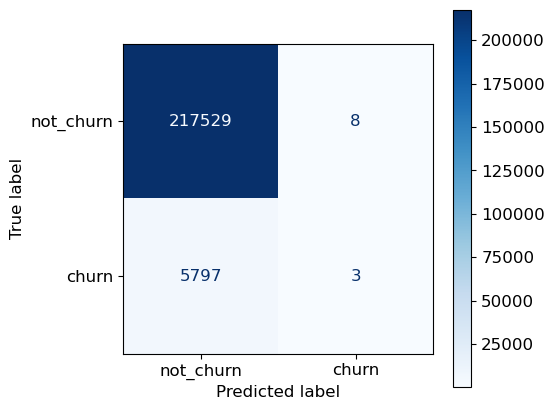

In [55]:
clf_ridge = RidgeClassifier() 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    217537
           1       0.00      0.00      0.00      5800

    accuracy                           0.97    223337
   macro avg       0.49      0.50      0.49    223337
weighted avg       0.95      0.97      0.96    223337



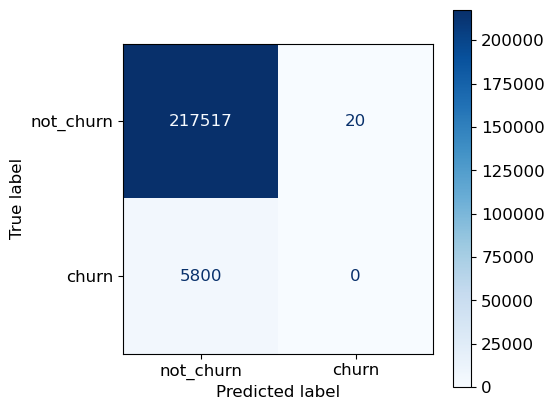

In [57]:
clf_ridge = LogisticRegression()  
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    217537
           1       0.33      0.10      0.15      5800

    accuracy                           0.97    223337
   macro avg       0.65      0.55      0.57    223337
weighted avg       0.96      0.97      0.96    223337



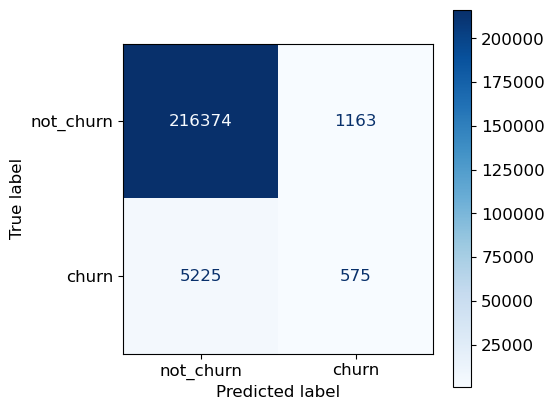

In [58]:
clf_ridge = DecisionTreeClassifier(random_state=0, max_depth=15) 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)
# from sklearn.tree import export_text
# r = export_text(clf_ridge, feature_names=list(X_train), decimals=0, spacing=6)
# print("prediction rule \n{}".format(r))

### not oversampling version

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    217537
           1       0.47      0.07      0.12      5800

    accuracy                           0.97    223337
   macro avg       0.72      0.53      0.55    223337
weighted avg       0.96      0.97      0.96    223337



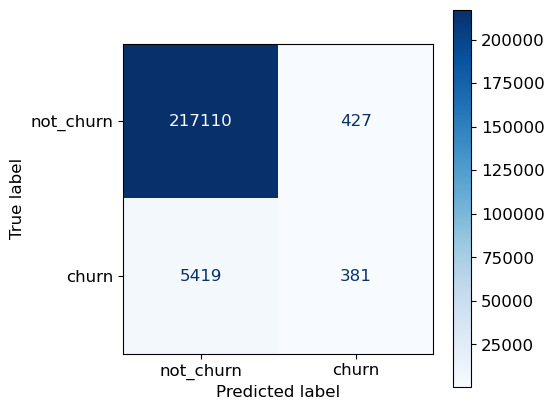

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = RandomForestClassifier() 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [132]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [133]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(100)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,pred,label
1656,9990013425750600,0.0,55362.0,32818.0,49453.0,161087.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1657,9990010003561956,0.0,44453.0,47271.0,52453.0,34179.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,10.0,1,0
2035,9990013419086912,0.0,286169.0,91360.0,36362.0,277263.0,0.0,2.0,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
2328,9990013410234730,0.0,77179.0,52816.0,72489.0,46672.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1,0
2466,9990017188009556,0.0,80815.0,53997.0,70542.0,72181.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,9.0,1,0
2826,9990013310245277,0.0,67634.0,63996.0,24635.0,78087.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
3053,9990010888643029,0.0,120726.0,137998.0,58543.0,59816.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1,0
4092,9990013402851920,26453.0,65908.0,19180.0,17000.0,18090.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,1,0
4125,9990012165256388,315810.0,429898.0,87090.0,51563.0,110078.0,6.0,8.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1,0
4435,9990012364813500,76630.0,72542.0,109269.0,66270.0,128267.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,6.0,1,0


In [128]:
X.head()

,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11
0,0.0,0.0,0.0,50362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1789791.0,1791590.0,2412654.0,3117811.0,15.0,20.0,35.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,27.0,46.0
2,82453.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86132.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,191267.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0


### oversampling version

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    217537
           1       0.33      0.35      0.34      5800

    accuracy                           0.96    223337
   macro avg       0.66      0.66      0.66    223337
weighted avg       0.97      0.96      0.97    223337



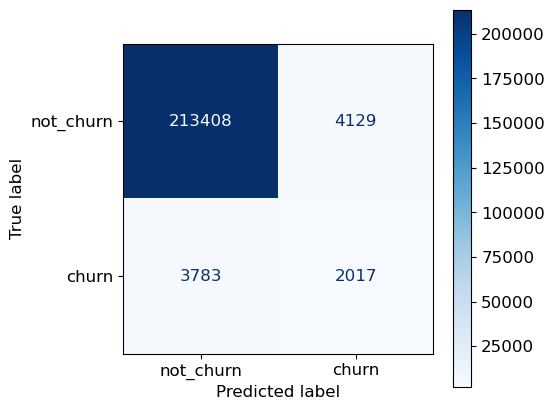

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)


clf_ridge = RandomForestClassifier() 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)


print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [135]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [136]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(100)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,pred,label
63,9990010320225939,641973.0,917377.0,684385.0,238491.0,796980.0,6.0,7.0,5.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,39.0,5.0,1,0
80,9990013071421500,1111920.0,1171709.0,773487.0,64544.0,373669.0,15.0,15.0,9.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,21.0,39.0,1,0
101,9990013412565960,0.0,166354.0,150811.0,40725.0,321623.0,0.0,2.0,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1,0
103,9990010543393972,200903.0,299790.0,42090.0,220902.0,290812.0,3.0,5.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,25.0,13.0,1,0
281,9990012528705410,92266.0,74905.0,116633.0,55180.0,36452.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,9.0,3.0,1,0
293,9990010239365300,356176.0,343541.0,294450.0,433993.0,398537.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,11.0,1,0
323,9990013373616524,208128.0,210904.0,189906.0,30998.0,36544.0,4.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,8.0,1,0
402,9990013214707470,12681.0,42043.0,9999.0,24726.0,16453.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0
475,9990012462017667,0.0,54908.0,260191.0,76544.0,71999.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1,0
493,9990013323943623,0.0,28362.0,84088.0,33089.0,35817.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,1.0,0.0,1,0


In [113]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(100)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,pred,label
24,9990010164603765,596131.0,1215242.0,167041.0,165814.0,0.0,4.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,16.0,20.0,0,1
40,9990012545923874,0.0,402903.0,401816.0,80861.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0,1
54,9990010624452922,0.0,43997.0,30090.0,17181.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,12.0,0,1
87,9990012722227689,327542.0,176181.0,406724.0,601083.0,0.0,3.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,6.0,0,1
105,9990012535530438,1417562.0,474343.0,202079.0,172262.0,0.0,10.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,4.0,0,1
157,9990013219757366,61817.0,61635.0,71908.0,72271.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0,1
191,9990013371552361,775899.0,1121940.0,1168790.0,87726.0,0.0,9.0,12.0,10.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0,1
203,9990013060441496,402175.0,151541.0,155451.0,84816.0,0.0,7.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,11.0,5.0,0,1
209,9990013278385500,12779152.0,1147429.0,1332886.0,150629.0,0.0,139.0,11.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,703.0,574.0,39.0,0,1
251,9990013311195700,1323718.0,1788896.0,889613.0,526352.0,0.0,7.0,10.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,12.0,2.0,0,1


In [ ]:
clf_ridge = DecisionTreeClassifier() 
clf_ridge.fit(X_train, y_train) 


pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
# def randomForest_fit(x_train, y_train, scoring = 'f1_macro'):
#     randomForest = RandomForestClassifier(random_state=123)

#     hyperparam = {'min_samples_leaf': [3, 5, 7, 9, 13, 17, 21, 27, 33, 41, 50, 60, 80, 100],
#                   'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75], 
#                   'n_estimators': [100, 200, 300, 500, 750, 1000]}
    
# #     random_randomForest = RandomizedSearchCV(randomForest, param_distributions = hyperparam, cv = 5, 
# #                                            n_iter = 6, scoring = scoring, n_jobs=-1, random_state = 123) 
# #     to long running time
#     random_randomForest = GridSearchCV(randomForest, param_grid = hyperparam, cv = 5, 
#                                         scoring = scoring, n_jobs=32)
#     random_randomForest.fit(x_train, y_train)
    
#     print ("Best F1", random_randomForest.best_score_)
#     print ("Best Param", random_randomForest.best_params_)
#     return random_randomForest

# best_randForest = randomForest_fit(X, y)

In [ ]:
# randForest = RandomForestClassifier(random_state=123, n_jobs = -1,
#                                    min_samples_leaf = best_randForest.best_params_.get('min_samples_leaf'),
#                                    max_features = best_randForest.best_params_.get('max_features'),
#                                    n_estimators = best_randForest.best_params_.get('n_estimators'))
# name = randForest.__class__.__name__
# randForest.fit(X_train, y_train) 
# pred = randForest.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [ ]:
# coba cek master member
# join dengan member id yang 8 angka
# cari create date dengan member yang terbaru

In [ ]:
import cx_Oracle
from sqlalchemy import event,create_engine,types

driver = 'cx_oracle'
server = '10.234.152.61' 
database = 'alfabi' 
username = 'report' 
password = 'justd0it'
engine_stmt = "oracle://%s:%s@%s/%s" % (username, password, server, database )

engine = create_engine(engine_stmt)

df = df_tto_re[['TRO_MEMBERS']]
dtyp = {c:types.VARCHAR(df[c].str.len().max()) for c in df.columns[df.dtypes == 'object'].tolist()}
df.to_sql('temp_churn', engine, index=False, if_exists="replace", dtype=dtyp)

engine.dispose()

In [ ]:
li_df_pv = []

for dr in pd.date_range('2021-11-01', '2021-11-30'):
    df_f = dr.strftime('%d-%b-%y')
    q = '''
    SELECT 
        tc.TRO_MEMBERS, 
        count(ame.AME_CART_PRODUCT_ID) AS COUNT_VIEW_PRODUCT
    FROM 
        TEMP_CHURN tc
        LEFT JOIN PLMS_MEMBER_PROFILE pmp 
        ON pmp.PMP_MEMBER_ID = tc.TRO_MEMBERS 
        LEFT JOIN ALFAGIFT_MOE_EVENTS ame 
        ON ame.AME_PONTA_ID = pmp.PMP_MEMBER_UNIQUE_ID 
        LEFT JOIN ALFAGIFT_MASTER_PRODUCT amp 
        ON amp.PRODUCT_ID = ame.AME_CART_PRODUCT_ID 
    WHERE 
        TRUNC(ame.AME_EVENT_TIME) BETWEEN '{}' AND '{}'
        AND ame.AME_EVENT_NAME = 'view_product'
    GROUP BY tc.TRO_MEMBERS

    '''.format(df_f, df_f)
    con = ds_db.connect_alfabi()
    df_pv = pd.read_sql_query(q, con)
    con.close()
    li_df_pv.append(df_pv)
    
df_pv.head(20)